# Quora Insincere Questions Part 1: Exploratory Data Analysis.

Digging into the [Quora Insincere Questions Classification](https://www.kaggle.com/c/quora-insincere-questions-classification) training data.

In this first pass I'm simply familiarizing myself with the types of questions in the training set. I will test some intuition about features that are likely or unlikely to correlate with insincere questions, topics like Trump, Black Lives Matter and Feminism vs topics like python programming. I will also look for other features that might be engineered for inclusion in a TF-IDF Naive-Bayes model, and words / terms / topics that may not map well to the text embedding datasets provided for use. 

### Competition Notes

From the competition description. Highlights mine:

An insincere question is defined as a **question intended to make a statement** rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

Has a non-neutral tone
Has an exaggerated tone to underscore a point about a group of people
Is rhetorical and meant to imply a statement about a group of people
Is disparaging or inflammatory
Suggests a **discriminatory** idea against a protected class of people, or seeks confirmation of a stereotype
Makes disparaging **attacks/insults** against a specific person or group of people
Based on an outlandish premise about a group of people
Disparages against a characteristic that is not fixable and not measurable
Isn't grounded in reality
Based on false information, or contains absurd assumptions
Uses **sexual content** (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers
The training data includes the question that was asked, and whether it was identified as insincere (target = 1). 

**The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.**

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import os
import math
pd.set_option('display.max_colwidth', -1)

## Import Training Data

In [3]:
# Select local path vs kaggle kernel
path = os.getcwd()
if 'data-projects/kaggle_quora/notebooks' in path:
    data_dir = '../data/raw/'
else:
    data_dir = ''

dat = pd.read_csv(data_dir +'train.csv')

In [4]:
dat.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [5]:
dat.shape

(1306122, 3)

## Getting a feel for insincere vs sincere questions

First lets take a look at the full text for a sample of "sincere" questions. They are shorter than I expected. Spelling is fairly good, grammer is a little spottier. Not an overabundance of typos.

In [6]:
# Sincere questions
for q in dat['question_text'][dat['target'] == 0].sample(10):
    print(q)

Working abroad as graphic designer, which country would you recommend?
What were the literary devices used in the book "Frozen" by Bill Scollon?
What if soldiers did not participate in war?
What would you do if your best friend told you that you are a horrible person and do not want to see you again?
Have you made any fantasy type films?
My 6 year old daughter suffers from severe androphobia, how can I help her?
How much time does it normally take between learning Android development without any relevant skills and prior coding experience, and publishing your first proper app?
What is the best way to get 1M comment on facebook post with the post like this https://www.facebook.com/thebananasmile/posts/2055051361445487?
What is it like to see a wonderful moment to see the retirement age of the 3 Khans so near?
Which are some interesting physics or biology topics to research on?


Initial impressions: 
Religious / cultural items:
"Why are Muslim beliefs tolerated and accepted, while Nazis beliefs are not, even when they are the same (e.g. belief in superiority over others, hate of homosexuals, disrespect for women)?"
"If a Hindu woman is not better than a Muslim woman according to Islam, why do Muslims approach Hindu women for love and marriage?"
"What will you do if you spot a Muslim having sex with a female dog?"

US Political and "liberal media" items:
"Is it possible for liberal agents in the FBI to abuse their authority while investigating Trump?"
"How do the news brainwash people into liberalism (appropriate answers only)?"
"Why is the Democrats' media suddenly miraculously concerned with the President's ethics and scandals? Not a peep during Obama's eight years."
"Is it ok for liberals to insult Trump supporters, but not ok for Trump supporters to insult liberals?"
"Why do liberals, when they don't have any arguments in political discussion, call the opponent ''racist'', ''sexist'', or ''xenophobic''?"
"Can Trump supporters read?"
"When will dictator Donald Trump be tried at the Hague?"
"Did liberals really believe that Trump's sons illegally shot and killed a Triceratops?"

Indian Political items:
"Does Prakash Raj think that the people of 20 states of India are fools to vote for Modi in assembly elections?"

Sexually "shocking" items:
"What does sex with a cousin feels like?"
"Does anyone of your aunt tries to have sexual relationship with you?"

Transphobic / homophobic items:
"Why do homosexual people exist in nature, it doesn’t make sense biologically speaking?"
"Does shaving buttocks make you gay?"

Misogynistic / anti-feminist items:
"Do women have emotions and feelings?"
"Why do feminists think they're for equal rights? When egalitarianism is the real way to achieve this?"
"Why do some bitches expect virgin guys as partners?"

Racist items:
"Why are blacks so uncivilized?"
"If we removed all blacks from Obamacare, would it be more affordable to real Americans?"

Nazi / holocaust items:
What happens when someone had diarrhea in the holocaust?
What is the politically correct spelling: Ass-con-Nazi or Ask-Ken-Nazi?

In [7]:
# Insincere questions
for q in dat['question_text'][dat['target'] == 1].sample(10):
    print(q)

Why do people act cheap asking to wave off service charge while paying the restaurant bill in India? Can they do the same in any other countries?
Why don't women lift the toilet seat back up after they're done using the toilet?
Why does the US buy so many goods from Indonesia, even though Indonesia is our enemy?
How can the Democrats call themselves "progressive" when their economic ideas are based on mid-20th century socialist ideology? Shouldn't they be adapting their platform to the 21st century globalized economy?
What is the best way to poison a cat which will make it die for sure?
Why are terrorists all Muslims?
Have you ever saw your son's penis erect?
How can we save Vietnamese from being brainwashed?
Do hijabi women realize they draw attention to themselves by looking like bald potato heads?
Why didn’t Europeans master horse riding and use bows like the Asian tribes that brought monsters like Attila the Hun and Genghis Khan?


Casual observations:
* Text appears longer
* More misspellings and gramatical issues, but not as much as I would have expected
* More strong language, eg. "stupid", "idiot", "hate", "irrational", "disgusting"...
* More likely to start with "Why" rather than "How", "What" or "Where".
* What do some "sincere" questions about Trump, liberals, Muslims and sex look like? I suspect those are going to be extremely tough to disambiguate.

In [8]:
trump_questions = dat['question_text'].apply(lambda x: "Trump" in x)

sincere_trump = dat[np.logical_and(trump_questions, dat['target'] == 0)]
insincere_trump = dat[np.logical_and(trump_questions, dat['target'] == 1)].sample(10).reset_index()

side_by_side_trump = pd.DataFrame({'sincere': sincere_trump['question_text'].sample(10).values,
                                                           'insincere': insincere_trump['question_text'].sample(10).values})

side_by_side_trump

,sincere,insincere
0,Will the truth survive Trump's practice of making it irrelevant?,Why won't the Democrats stop blaming Russia for Trump's win?
1,Are congressional republicans at all concerned that allowing Trump to remain in office will destroy the party as well as democracy itself?,Do you hate Trump? I mean HATE Trump like I do?
2,"How many Presidents has the United States of America had, not including Donald Trump?",Donald Trump promised to have Hillary Clinton tried for her crimes against the United States. She is truthfully a criminal to enormous proportion. Why hasn't Donald Trump complied with his campaign promise?
3,Does Trump get the same classified briefings as the Intel agencies that are investigating him?,"Is it just me who feels that astrology is a pseudoscience, because if it was well recognized and accepted Trump wouldn't be allowed to be a President, being he is a Gemini?"
4,"Barack Obama spent a lot of time in Asia, as part of his so-called 'pivot' to Asia. Is Trump planning to continue on that path? What can Trump offer Asia?","If CNN published a completely fabricated story that compliments and praises Donald Trump, would his ego allow him to call them out for publishing a fake news article?"
5,Does US Code 227 hold any weight in court regarding Donald Trump's recent attacks on NFL players?,Did Donald Trump fu*k a 13 yr old child?
6,"Does Mr. Trump know the difference between one ""mass shooting"" and another (his 'tweets' on the latest one seems to indicate otherwise)?","What would be the best and last option for President Donald Trump and his legal team, to stop Stormy Daniels from mocking the USA presidency: When we consider her theatrics like ""Make America Horny Again Tour""?"
7,Who is more unpatriotic Trump for dodging the draft six times or NFL players for taking a knee during national anthem?,Do liberals at least admire Trump’s confidence and optimism? He knew from the beginning that he’d win.
8,What does it say about a person who unfriends you on Facebook because you don't like Trump?,Donald Trump wants to imprison people who don't agree with him. Can people wake up and realize he's a dictator?
9,"If Donald Trump is impeached and indicted, is it likely that Mike Pence would also be implicated?","Jason Aldean publicly called out Trump and look what happened at one of his concerts. Comedians are scared to joke about Trump and now even protesting is wrong, if he says so. What's next?"


These were classed as "sincere":

"If everyone agrees that Trump is a total failure as president, why is he still president?"
"Will Trump stage a terrorist attack to gain support for himself and save his administration?"
"Why are Conservatives so lazy that they have put faith in Trump uplifting their lives?"

And this is "insincere":
"Why would President Trump push to move the embassy to Jerusalem? What possible benefit is there to the United States?"

So we can see this is an unevenly applied classification, presumably by human moderators who are doing their darndest. This will be difficult to classify, and I would say that Quora should probably have an iterative model-review-reclassify-remodel process to improve the quality of their tagging, particularly for high-value topics.

### Can we identify some frequently insincere topics by inspection or other research?

#### US Political

In [9]:
topics = ['trump', 'hillary', 'liberal', 'russia', 'spies', 'pizzagate', 'liberal media']

insincere_count = 0
questions_count = 0

def calculate_word_target_proportions(df, words, verbose=True):
    print('{}% insincere - overall ({} / {})'.format(100*df.target.mean().round(3),
                                                    df.target.sum(),
                                                    len(df.target)))
    props = []
    insincere_count = 0
    questions_count = 0
    for word in words:
        filter = df['question_text'].apply(lambda x: word in x.lower())
        if filter.sum() > 0:
            props.append([(100*df[filter].target.mean()).round(1), 
                                                            word,
                                                           df[filter].target.sum(),
                                                           len(df[filter].target)])
            insincere_count += df[filter].target.sum()
            questions_count += len(df[filter].target)

    if verbose:
        for prop in sorted(props, reverse=True):
            print('{0}% insincere - {1} ({2} / {3})'.format(*prop))
        
    return props, insincere_count, questions_count
        
p, i, q = calculate_word_target_proportions(dat, topics)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
70.5% insincere - liberal media (43 / 61)
63.7% insincere - liberal (2756 / 4324)
63.5% insincere - hillary (785 / 1236)
61.1% insincere - pizzagate (11 / 18)
43.5% insincere - trump (6145 / 14128)
23.8% insincere - russia (1374 / 5778)
21.4% insincere - spies (27 / 126)


#### Race, Religion and Cultural Identities

In [10]:
race_rel_culture = ['black', 'black lives','muslim']
p, i, q = calculate_word_target_proportions(dat, race_rel_culture)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
69.5% insincere - black lives (73 / 105)
59.0% insincere - muslim (4725 / 8009)
37.7% insincere - black (3155 / 8376)


#### Gender & Sexual Orientation

In [11]:
gender_sex = ['woman', ' man', 'women', 'trans ', ' men', 'dyke', 'fag', 'queer', 'femin', 'transgender']

p, i, q = calculate_word_target_proportions(dat, gender_sex)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
51.0% insincere - femin (981 / 1922)
43.2% insincere - women (5323 / 12323)
42.9% insincere - dyke (3 / 7)
42.2% insincere - transgender (341 / 808)
35.4% insincere - trans  (90 / 254)
30.8% insincere - fag (8 / 26)
29.6% insincere -  men (4352 / 14706)
22.8% insincere - woman (1194 / 5246)
21.6% insincere - queer (16 / 74)
11.0% insincere -  man (5317 / 48404)


#### Sex & Anatomy

In [12]:
sex_anatomy = ['sex', 'boob', 'butt', ' ass', 'asshole', 'bollok', 'blow job', 'blowjob', 'bugger'
              'boner', 'buttplug', 'dildo', 'clitoris', 'cock', 'cunt', 'twat', 'pube', 'vagina', 
               'wank', 'whore', 'hooker']

p, i, q = calculate_word_target_proportions(dat, sex_anatomy)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
77.1% insincere - cunt (54 / 70)
69.7% insincere - asshole (168 / 241)
61.3% insincere - whore (65 / 106)
46.5% insincere - blowjob (53 / 114)
45.9% insincere - wank (17 / 37)
41.8% insincere - hooker (23 / 55)
37.1% insincere - boob (109 / 294)
33.3% insincere - buttplug (1 / 3)
33.3% insincere - blow job (16 / 48)
30.6% insincere - vagina (190 / 621)
30.0% insincere - dildo (18 / 60)
29.7% insincere - sex (4350 / 14664)
27.3% insincere - clitoris (9 / 33)
24.2% insincere - cock (149 / 616)
13.6% insincere -  ass (1249 / 9165)
13.0% insincere - butt (264 / 2026)
10.5% insincere - pube (27 / 257)
5.8% insincere - twat (7 / 120)


#### Words associated with bullying / trolling / insults

Taisei Nitta, Fumito Masui, Michal Ptaszynski, Yasutomo Kimura, Rafal Rzepka, and Kenji Araki. 2013. Detecting
cyberbullying entries on informal school websites based on category relevance maximization. In IJCNLP,
pages 579–586.

Raisi, et al (2016)

In [13]:
trolling = ['disgust', 'hate', 'idiot', 'stupid', 'irrational', 'annoying', 
            'gross', 'slut', 'fellatio', 'die', 'kill', 'faggot', 'fag', 'pathetic', 'pussy',
           'nigger', 'ignorant', 'lying', 'communist', 'trash', 'dumb', 'worthless',
           'nazi', 'jerk', 'asshole', 'dick', 'prick']

p, i, q = calculate_word_target_proportions(dat, trolling)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
69.7% insincere - asshole (168 / 241)
65.9% insincere - pussy (149 / 226)
65.2% insincere - ignorant (313 / 480)
64.9% insincere - idiot (347 / 535)
64.3% insincere - nigger (27 / 42)
54.5% insincere - dick (331 / 607)
53.7% insincere - slut (95 / 177)
51.0% insincere - stupid (1066 / 2091)
46.2% insincere - fellatio (6 / 13)
42.9% insincere - faggot (6 / 14)
37.9% insincere - dumb (451 / 1189)
37.8% insincere - hate (2670 / 7067)
37.6% insincere - disgust (163 / 434)
37.1% insincere - nazi (530 / 1427)
36.1% insincere - jerk (99 / 274)
34.5% insincere - trash (118 / 342)
31.8% insincere - prick (14 / 44)
31.8% insincere - pathetic (112 / 352)
30.8% insincere - fag (8 / 26)
30.4% insincere - communist (261 / 858)
20.2% insincere - irrational (57 / 282)
18.8% insincere - kill (2070 / 11009)
18.7% insincere - worthless (32 / 171)
18.4% insincere - annoying (115 / 624)
9.9% insincere - lying (326 / 3302)
9.2% insincere - gross (29 / 315)
7.4% ins

#### Curses!

In [14]:
curse = ['asshole', 'fuck', 'cunt', 'ass', 'bastard', 'bitch', 'bugger', 'crap', 'damn', 'f u c k', 'feck'
        'hell ', 'piss', 'poop', 'turd']

p, i, q = calculate_word_target_proportions(dat, curse)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
77.1% insincere - cunt (54 / 70)
69.9% insincere - fuck (709 / 1014)
69.7% insincere - asshole (168 / 241)
59.1% insincere - bitch (146 / 247)
54.8% insincere - bastard (51 / 93)
50.0% insincere - damn (79 / 158)
35.0% insincere - piss (78 / 223)
29.7% insincere - poop (107 / 360)
21.8% insincere - crap (119 / 547)
10.9% insincere - turd (25 / 230)
8.2% insincere - ass (3248 / 39664)
0.0% insincere - bugger (0 / 6)


Context is pretty important here. Danescu-Niculescu-Mizil's corpus is based on Stack Exchange comments, which are inherently non-poltical. I can see how "You're welcome" and "Thanks a lot" could be associated with false-sincerity or straight sarcasm on Quora.

So I guess, in Quora's case, "Welcome" isn't very welcoming! :P

#### Complaining About the Platform?

In [15]:
quora = ['quora']

p, i, q = calculate_word_target_proportions(dat, quora)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
21.0% insincere - quora (3442 / 16380)


#### Conclusion

In [16]:
print('Targets: {} / Overall Targets: {}. {}%'.format(insincere_count, dat['target'].sum(),
                                                      (100*insincere_count/dat['target'].sum()).round(1)))
print('Questions: {} / Overall Questions: {}. {}%'.format(questions_count, len(dat['target']),
                                                          round(100*questions_count/len(dat['target']),1)))

Targets: 62377 / Overall Targets: 80810. 77.2%
Questions: 260736 / Overall Questions: 1306122. 20.0%


There's double counting in here, I'd have to check how much, but these terms account for approximately 19% of questions but 78% of insincere questions.

Answer: yes, very much so. References to Liberals and Hillary, the Holocaust and Muslims are flagged as insincere in well over 50% of occurances. References to Trump are insincere over 40% of the time, which is a lot given the base rate is only 6%. So these words along will be strong signals. But there are sincere questions about, say, Trump. An easy model would simply flag all questions about Liberals and Hillary as insincere, and possibly do quite well overall.

What will be interesting is the nuance between sincere and popular questions on topics that are frequenly insincere. Consider modelling frequent topics with high target rates separately and ensembling.

TODO: Cluster analysis / topic modelling for targets to see if any other themes can be identified.

### Words associated with politeness

Hey, there's some research on identifying *politeness*! This is the opposite, perhaps useful as a feature for non-targets?
http://www.cs.cornell.edu/~cristian/Politeness.html

In [17]:
politeness = ['thanks', 'thank you', 'appreciate', 'awesome', 'please', 'share', 'welcome']
p, i, q = calculate_word_target_proportions(dat, politeness)

6.2% insincere - overall (80810 / 1306122)
21.9% insincere - welcome (71 / 324)
13.6% insincere - thanks (59 / 435)
12.0% insincere - please (255 / 2124)
11.4% insincere - appreciate (61 / 537)
7.5% insincere - thank you (21 / 279)
6.7% insincere - awesome (22 / 327)
4.1% insincere - share (174 / 4277)


### What about Internet Abbreviations?

In [18]:
internet = ['lol', 'rolf', 'yolo', 'lmfao', 'stfu', 'omg', 'lmk', 'smh', 'nvm', 'ikr']
p, i, q = calculate_word_target_proportions(dat, internet)

6.2% insincere - overall (80810 / 1306122)
100.0% insincere - smh (1 / 1)
17.6% insincere - stfu (12 / 68)
17.5% insincere - lol (41 / 234)
15.6% insincere - omg (5 / 32)
9.1% insincere - rolf (1 / 11)
4.0% insincere - yolo (1 / 25)
1.4% insincere - ikr (1 / 71)
0.0% insincere - nvm (0 / 6)
0.0% insincere - lmk (0 / 1)
0.0% insincere - lmfao (0 / 1)


Not very common and not very strong signals. Ok then!

## Question Structure

### Leading Why vs How / Which / What?

In [19]:
dat['leading_word'] = dat['question_text'].apply(lambda x: x.split()[0].lower())

In [20]:
summary = dat.groupby('leading_word')['target'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
summary['percent_of_qs'] = summary['count'].apply(lambda x: round(100*x/dat.shape[0],1))
summary = summary.rename(columns={'mean': 'percent_targets'})
summary.loc[summary['percent_of_qs'] > 1,['percent_targets', 'percent_of_qs', 'count']]

,percent_targets,percent_of_qs,count
leading_word,,,
why,0.225128,10.3,134621
are,0.146523,2.0,25839
do,0.133801,2.7,35523
if,0.104519,2.1,27641
is,0.068536,7.3,95191
does,0.061599,1.5,20179
i,0.059630,1.6,20560
who,0.034198,1.6,21054
can,0.029351,3.7,48482


Leading Whys are overwhelmingly far more likely to be insincere! 
I wonder linguistically what is going on there...

Is it that "why" and (to a lesser extent) "are" lead questions confirmatory phrasing? In that you're trying to get someone to agree with an initial premise. "Why are Xs into Z?" or "Are all Xs into Z"?

### Word & Character Count

In [21]:
dat['char_count'] = dat['question_text'].apply(len)
dat['word_count'] = dat['question_text'].apply(lambda x: len(x.split()))

In [22]:
dat[['char_count','word_count','target']].groupby('target').mean()

,char_count,word_count
target,,
0,68.872758,12.508533
1,98.064163,17.277812


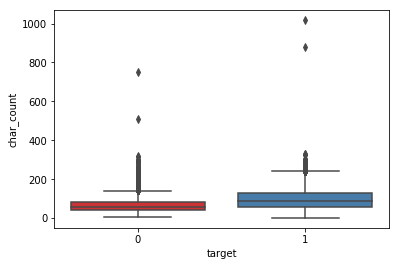

In [23]:
sns.boxplot(x="target", y="char_count", data=dat, palette="Set1")

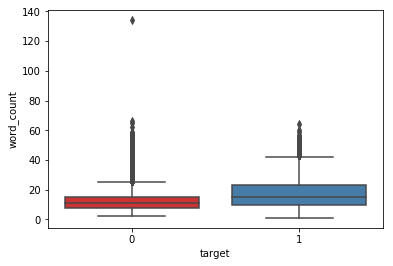

In [24]:
sns.boxplot(x="target", y="word_count", data=dat, palette="Set1")

### How many questions?

Are people who ask many questions at once more likely to be insincere?

In [25]:
dat['question_mark_count'] = dat['question_text'].apply(lambda x: x.count('?'))

In [26]:
dat[['question_mark_count','target']].groupby('target').mean()

,question_mark_count
target,
0,1.052672
1,1.130306


In [27]:
dat.loc[dat.question_mark_count > 1, ['question_text', 'target', 'question_mark_count']].sample(10)

,question_text,target,question_mark_count
464675,"How do I convince my mom to let me do my own hair? I’m 13, about to go into high school. I get straight A’s and I’m kind and nice. Why won’t she let me take care of myself?",0,2
424664,Should I think before or during writing? Why or why not?,0,2
1194979,Are teams getting better at football? Are the best teams around today better than the best teams of 50 years ago?,0,2
697018,Why didn’t the UK and France give the Mongolian Gypsies (Turks) a country on their own land? Why did they create the artificial state (Turkey) in Anatolia?,0,2
228714,How much energy is required to power a Star Trek phaser? Theoretically?,0,2
1162140,When did you reveal yourself as a psycopath and why? Did you have any bad repercutions for it?,0,2
413327,"Should one join DU (any college) or St. Xaviers Kolkata for eco (hons) ? Also, how will my choice effect my civil services exam preparation?",0,2
277667,Whom should I choose between Capricorn or Taurus for Marriage? I am Capricorn?,0,2
1116044,"Why are sanitary pads available to only 12% of women in India and taxed, aren't Indians ashamed of this and the fact that so many girls miss school because they are menstruating? Is the Hindu Nationalistic government responsible for this?",0,2
544768,What would happen if the Avengers tried to eradicate fire ants from the earth? Would they be able to do it?,0,2


Very small difference, I'm not terribly excited about this as a feature.

### Math Questions

In [35]:
import re
dat['math_symbols'] = dat['question_text'].apply(lambda x: len(re.findall("∩|∈|ℝ|∀|φ|θ|ψ|\||√|=|//math|//code",x))>1)

In [39]:
dat.loc[np.logical_and(dat.math_symbols,dat.target==1), ['question_text','math_symbols', 'target']].sample(10)

,question_text,math_symbols,target
38634,As [math]x\to\infty\displaystyle\lim_{x=1}\frac{d_{x}}{\left(x+1\right)^{2}}=1[/math] how can we prove [math]\left[a_{x}<b_{x}<c_{x}<d_{x}\right]\in X_{x}\mapsto X_{x+1}[/math] and [math]\left(d_{x}-1\right)-\left(a_{x}-1\right)=3x [/math]?,True,1
327381,"Which of the options listed below would most accurately fit [math](f ∘ g)(x),f(x) = \frac{x}{x+4}, g(x) = \frac{7}{x}[/math]? —A.[math](f ∘ g)(x) = \frac{7x+28}{x}[/math] —B.[math](f ∘ g)(x) = \frac{7x+4}{x}[/math] —C.[math](f ∘ g)(x) = \frac{7}{7+4x}[/math] —D.[math](f ∘ g)(x) = \frac{7x+28}{11}[/math]",True,1
163583,What is [math]\overbrace{\sum_{\vartheta=8}^{\infty} \vec{\frac{\sum_{\kappa=7}^{\infty} \overbrace{1x^0}^{\text{Read carefully.}}-3x^{-1} \div 1x^5+{\sqrt[3]{2x^{-3}}}^{1x^0}+\vec{\vec{{3x^{-3}}^{1x^{-2}}}}}{\sum_{\dagger=9}^{\infty} \vec{\boxed{\boxed{3x^{-1}}+3x^1 \times 1x^{-5}}}}} \div \sin(\boxed{\boxed{\vec{3x^{-5}}}+\sqrt[4]{2x^{-4}}+\vec{2x^{-3}} \div \sin(\sqrt[5]{\int_{1x^5}^{2x^5} 2x^{-3} d\varrho}) \times \vec{{\underbrace{2x^1}_{\text{Prove This.}}}^{3x^4} \div \sqrt[5]{2x^{-3}}+\sum_{\theta=8}^{\infty} 1x^4}}) \times {\boxed{\vec{\sum_{\nu=8}^{\infty} \sum_{4=6}^{\infty} \sum_{\xi=9}^{\infty} \boxed{3x^1}-\boxed{\sqrt[3]{\sqrt[3]{2x^{-2}}}}}}}^{1x^3}-\cos({{\tan(\sum_{0=6}^{\infty} \tan(\overbrace{\frac{\boxed{1x^1}-\sqrt[3]{3x^{-2}}}{\sum_{\eta=10}^{\infty} 1x^{-3} \div 1x^1}}^{\text{Molar Quantity.}}))}^{1x^3}}^{1x^{-4}})}^{\text{Expanded.}}[/math]?,True,1
443216,What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{\chi=6}^{\infty} \int_{1x^4}^{2x^{-4}} 3x^2 d\vartheta+{2x^{-3}}^{2x^{-5}}}^{3x^{-4}}}} d\mu) d\iota}[/math]?,True,1
315732,"[math]\frac{\text{d}x}{\text{d}t}=Ax , {\text{d}x} x^{-1}=A {\text{d}t} [/math] , [math]{\text{now taking transpose on both sides}}[/math] [math] \int_{C}^{x} x^{-T}{\text{d}x^{T}}=\int_{0}^{t}A {\text{d}t} {\text{ solution becomes }} {\text x =(e^{t^{T}A^{T}})^{T} C}, {\text {but actual answer } x = (e^{At}) C, how?} [/math]",True,1
841016,How do I evaluate [math]\displaystyle\lim _{ h\rightarrow \infty }{ \left( \sum _{ i=1 }^{ i=h }{ \frac { \left( \left( \sum _{ j=1 }^{ j=i }{ \frac { \left( 2j+1 \right) ! }{ \prod _{ k=1 }^{ k=j }{ \left( 2k-1 \right) } } } \right) +2 \right) }{ { \left( (i+1)! \right)}^{ 2 } } } \right) }[/math]?,True,1
451521,Does NO Leftist understand that THIS is WHY Donald Trump is so successful!? https://www.quora.com/Why-dont-people-understand-Donald-Trump?share=fe457a6f&srid=p3dW4,True,1
528304,How would I solve [math]\lim_ {θ \to 0^+} \dfrac{A(θ)}{B(θ)} [/math]from the attached photo? I’m not sure if I’m supposed to substitute A([math]θ[/math]) and B([math]θ[/math]) as the area of the triangle and the area between the chord and the arc.,True,1
1297971,Why do some people not possess the necessary IQ to write [math]\sum \limits_{n=0}^{\infty}[/math] instead of [math]\sum_{n=0}^{\infty}[/math]?,True,1
397785,“><img src=x onerror=prompt(1)>,True,1


In [40]:
dat.loc[np.logical_and(dat.math_symbols,dat.target==0), ['question_text','math_symbols', 'target']].sample(10)

,question_text,math_symbols,target
97715,"Given the function f(x) =x^2-3bx+(c+2), determine the values of b and c such that f(1) =0 and f'(3) =0?",True,0
1121307,"What will be the perimeter of a parallelogram ABCD when E is a point in AD and CE produced meets BA produced at point F and AE=4 cm,AF=8 cm and AB=12 cm?",True,0
949445,What is the meaning of θιοψʼ in Ancient Greek?,True,0
640750,What is the derivative of [math]f(x) = \sum_{n=1}^{x} 1/n[/math]?,True,0
507422,How does this simultaneous equation question work? 2G + 3h= 1/ 5g - 2h= -26. I tried multiplying so that the numbers would cancel out but ended up with fractions?,True,0
1247286,"Can I get student visa if I have IELTS score of L=7.5, R=6.5, W=7, S=7 for the course of community services in Sydney?",True,0
1138491,"X + y = z and x * y = z. If x, y, and z are all positive numbers, what are the values of x, y, and z?",True,0
165301,"Can someone identify this Indian folk song? Links are: https://www.youtube.com/watch?v=p5bqAKixgYA&t=1335 https://www.youtube.com/watch?v=p5bqAKixgYA&t=22m15s If neither time format works, the song is at 22:15.",True,0
238071,"What does it mean, The formaction attribute is used with type=""submit"" and type=""image""?",True,0
882605,"What is the range of k if [math]f(x)=/frac{5-3x}{x^2+4x+k}[/math] is continuiable for [math]∀, x ∈ R[/math]?",True,0


In [42]:
dat[['math_symbols', 'target']].groupby('math_symbols').agg(['sum','count','mean'])

target                   
                sum    count      mean
math_symbols                          
False         80793  1305077  0.061907
True          17     1045     0.016268

This regex picks up very small number of non-math items. It seems that a few math formula questions are marked insincere. Are these math trolls? Oh, maybe they mark as insincere if the formula doesn't render?

Either way, math questions tend to be sincere. But many of the preprocessing steps will strip and omit these characters. So these features should be added first.

### Web Links

In [48]:
dat['web_links'] = dat['question_text'].apply(lambda x: len(re.findall("www/.|http:|https:",x))>0)

In [49]:
dat.loc[np.logical_and(dat.web_links,dat.target==0), ['question_text','web_links', 'target']].sample(10)

,question_text,web_links,target
303916,Is my blog post too long or too short? https://pennymattersblog.wordpress.com/,True,0
1246829,"COPE WITH CANCER , a NGO is legitimate ?https://www.copewithcancer.org/hair-donation",True,0
9304,Laws in India: Is it legal to take Bhang [ http://en.wikipedia.org/wiki/Bhang ] to Bangalore which I legally purchased in Rajasthan?,True,0
263321,"What kind of software used to create video like this ""http://y2u.be/nqlB8-rrRnQ"" ?",True,0
671762,"Why is Twitter censoring tweets, when I specifically told it not to?See: https://support.twitter.com/articles/20169199",True,0
712652,I recently wrote a blog post on 12 things that every twenty something will experience https://breathingabstract.com/12-things-every-twenty-something-will-experience/ . Are there more experiences that are common for the majority of twenty somethings?,True,0
1084080,"Can I earn money from my YouTube channel, https://www.youtube.com/edit?o=U&video_id=ECOWjlFPQlM?",True,0
1078105,Why do you think this painting hasn't sold? https://www.dropbox.com/s/1p2qr0jzo8vq16x/Screenshot%202017-07-22%2011.53.48.png?,True,0
419203,Is this a trustable website for information on weapons used in the past by Thailand http://www.parathikarn.police.go.th/web/sp/gun/Bar%20.html?,True,0
696651,What did Casey Neistat say at 8:38 in a video? https://www.youtube.com/watch?v=84WIaK3bl_s&ab_channel=CaseyNeistat. I'm not a native speaker just.,True,0


In [46]:
dat[['web_links', 'target']].groupby('web_links').agg(['sum','count','mean'])

target                   
             sum    count      mean
web_links                          
False      80770  1305640  0.061862
True       40     482      0.082988

Not very frequent. Looks slightly more likely to be insincere w/ a link.

### Programming Languages

Quora has a healthy community of people discussing programming languages. My intuition is this group would see fewer trolls than politically oriented parts of Quora, but the languages may not be well recognized in word embeddings sourced from news articles.

Using [Stack Overflow Developer Survey 2018](https://insights.stackoverflow.com/survey/2018/) as a guide, lets look into the appearance of major languages and frameworks.

Note that some of these have other meanings, like Ruby, or might be hard to match, such as the letters "R" or "C".

In [71]:
programming_languages_frameworks_dbs = ['javascript', 'html', 'css', 'sql', 'java', 'bash', 'python',
                                        'c#', 'c++', 'c language', 'c programming', 'c programing', 'typescript', 'ruby', 'matlab', 'f#', 'clojure', 
                                        'haskell', 'erlang', 'coffeescript', 'cobol', 'fortran',
                                        'vba', '.net', 'scala', 'perl', 'php', 'kotlin',
                                        'node.js', 'react.js', 'angular', 'django', 'cordova', 'tensorflow', 'keras',
                                        'xamarin', 'hadoop', 'pytorch', 'mongo', 'redis', 'elasticsearch', 'mariadb', 'azure',
                                        'dynamodb', ' rds', 'redshift', 'cassandra', 'apache hive', 'bigquery', 'hbase',
                                        'linux', 'raspberry pi', 'rpi ', 'arduino', 'heroku', 'drupal', 
                                        'visual studio', 'sublime text', 'rstudio', 'jupyter', 'pycharm', 'netbeans',
                                       'emacs', 'vim ', 'komodo']

p, i, q = calculate_word_target_proportions(dat, programming_languages_frameworks_dbs)

6.2% insincere - overall (80810 / 1306122)
39.4% insincere - bash (115 / 292)
20.0% insincere - mongo (107 / 534)
16.7% insincere - f# (2 / 12)
7.4% insincere - redis (7 / 95)
7.1% insincere - cordova (1 / 14)
5.1% insincere - perl (51 / 991)
4.0% insincere - rpi (19 / 474)
3.7% insincere - scala (10 / 267)
3.3% insincere - komodo (1 / 30)
1.2% insincere - html (8 / 641)
1.2% insincere - .net (4 / 324)
1.0% insincere - ruby (2 / 210)
0.7% insincere - c language (2 / 270)
0.5% insincere - css (2 / 408)
0.5% insincere - c++ (4 / 886)
0.4% insincere - java (10 / 2742)
0.4% insincere - hadoop (1 / 235)
0.3% insincere - python (4 / 1190)
0.3% insincere - linux (3 / 933)
0.2% insincere - php (1 / 630)
0.0% insincere - xamarin (0 / 64)
0.0% insincere - visual studio (0 / 107)
0.0% insincere - vim  (0 / 21)
0.0% insincere - vba (0 / 60)
0.0% insincere - typescript (0 / 21)
0.0% insincere - tensorflow (0 / 74)
0.0% insincere - sublime text (0 / 11)
0.0% insincere - sql (0 / 650)
0.0% insincere 

In [78]:
print("This word set covers {} insincere / {} questions ({}%), representing {}% of training set".format(
    i,
    q,
    round(100*i/q,2),
    round(100*q/dat.shape[0],2)))

This word set covers 354 insincere / 15214 questions (2.33%), representing 1.16% of training set


In [69]:
# R is almost always a slang version of "are". This needs to be fixed in pre-processing, 
# it doesn't seem as though there are enough obvious R statistics questions to worry about it. 
# This seems plausible given how few matlab and even python questions there are.
dat.question_text[dat.question_text.apply(lambda x: ' r ' in x and 'stat' in x)]

93320      What are the contents of r and statistics to restart a career?                                                                                              
175457     Let's say you wanted to do a statistical test to calculate the r value for two groups (male/female) and their use of gym equipment (upper body/lower body).?
688273     How many states r there in India?                                                                                                                           
1101788    If p, q r are electro negativity, ionization energy and electron affinity respectively the r=2p-q. is this statement correct? If yes how do you prove it?   
Name: question_text, dtype: object

In [67]:
# C is a mixed bag. Often relates to C programming. Occasionally music, other math problems, or just something else altogether
dat.question_text[dat.question_text.apply(lambda x: ' c ' in x)].sample(10)

838095     Why do we use include in c programme?                                                                                                                                                                                                           
1193588    How can modern people survive so long without vitamin c compared to sailors who died of scurvy?                                                                                                                                                 
13399      Why we have to learn c language? Why computer can't understand English?                                                                                                                                                                         
778426     What is the speed in terms of c that a spacecraft need to reach in order to travel to Alpha Centauri in just 1 second from the point of view of the moving astronaut?                                                                    

#### Programming Languages Conclusions
Programming questions represent about 1% of training data, but are low-frequency insincere, so identifying them well should be beneficial.
The letters "R" and "C" will need to be handled in preprocessing. "C++", "C#", "F#" should also be identified prior to stripping punctuation.